In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

from models import encoding

Using TensorFlow backend.


In [2]:
LEARNING_RATE=0.5
BATCH_SIZE = 64
HIDDEN_NODES = 128
NUMBER_OF_LAYERS = 2
EMB_SIZE=100
EPOCHS=30

In [3]:
data = pd.read_excel('Arabizi-Arabic Parallel corpora.xlsx', header=None, skiprows=1)
data = data.sample(frac=1, random_state=0)

data_input = [str(s).strip().lower() for s in data[0]]
data_output = [str(s).strip() for s in data[1]]
print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)

# We will use the first 0-60th %-tile (60%) of data for the training
range_of_train = int(data_size*60/100)

training_input  = data_input[0: range_of_train ]
training_output = data_output[0: range_of_train ]

# We will use the first 60-70th %-tile (10%) of data for the training
range_of_train = int(data_size*60/100)
range_of_val = int(data_size*70/100)

validation_input = data_input[range_of_train:range_of_val]
validation_output = data_output[range_of_train: range_of_val]

print('training size', len(training_input))
print('validation size', len(validation_input))

tjaweb تجاوب
arb3a2 اربعاء
training size 12899
validation size 2150


In [4]:
INPUT_LENGTH=0
OUTPUT_LENGTH=0
for i in data_input:
    if len(i)>INPUT_LENGTH:
        INPUT_LENGTH=len(i)
for i in data_output:
    if len(i)>OUTPUT_LENGTH:
        OUTPUT_LENGTH=len(i)
print("max input len=", INPUT_LENGTH,"\nmax output len=",OUTPUT_LENGTH)

max input len= 19 
max output len= 12


## Transform data into Numpy arrays
We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in encoding module.

First, encoding.build_characters_encoding will build encoding/decoding dictionary from the data.
Then, encoding.transform will transform the data into numpy array.

In [5]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('English character dict size:', input_dict_size)
print('Arabic character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

English character dict size: 52
Katakana character dict size: 41
encoded_training_input (12899, 19)
encoded_training_output (12899, 12)
encoded_validation_input (2150, 19)
encoded_validation_output (2150, 12)


# Sequence-to-Sequence in Keras

In [6]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder


In [7]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, EMB_SIZE, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(HIDDEN_NODES, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, EMB_SIZE, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(HIDDEN_NODES, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(?, 19, 128), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 128), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 12, 128), dtype=float32)


### Attention Mechanism
Reference: <a href="https://arxiv.org/pdf/1508.04025.pdf">Effective Approaches to Attention-based Neural Machine Translation</a>'s Global Attention with Dot-based scoring function (Section 3, 3.1)

In [8]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(HIDDEN_NODES, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)

attention Tensor("attention/truediv:0", shape=(?, 12, 19), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(?, 12, 128), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 12, 256), dtype=float32)
output Tensor("time_distributed_2/Reshape_1:0", shape=(?, 12, 41), dtype=float32)


In [72]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [73]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [74]:
history = None
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    history = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=BATCH_SIZE, epochs=EPOCHS)

model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=BATCH_SIZE, epochs=5)

model.save('model.h5')

Train on 12899 samples, validate on 2150 samples
Epoch 1/30
 - 15s - loss: 0.0641 - acc: 0.9809 - val_loss: 0.4048 - val_acc: 0.9055
Epoch 2/30
 - 8s - loss: 0.0550 - acc: 0.9835 - val_loss: 0.4426 - val_acc: 0.8943
Epoch 3/30
 - 8s - loss: 0.0506 - acc: 0.9847 - val_loss: 0.3994 - val_acc: 0.9069
Epoch 4/30
 - 8s - loss: 0.0482 - acc: 0.9858 - val_loss: 0.4510 - val_acc: 0.8976
Epoch 5/30
 - 8s - loss: 0.0447 - acc: 0.9870 - val_loss: 0.4232 - val_acc: 0.9053
Epoch 6/30
 - 8s - loss: 0.0408 - acc: 0.9883 - val_loss: 0.4258 - val_acc: 0.9022
Epoch 7/30
 - 8s - loss: 0.0398 - acc: 0.9886 - val_loss: 0.4371 - val_acc: 0.9055
Epoch 8/30
 - 8s - loss: 0.0371 - acc: 0.9893 - val_loss: 0.4293 - val_acc: 0.9064
Epoch 9/30
 - 8s - loss: 0.0335 - acc: 0.9906 - val_loss: 0.4285 - val_acc: 0.9080
Epoch 10/30
 - 8s - loss: 0.0322 - acc: 0.9911 - val_loss: 0.4551 - val_acc: 0.9028
Epoch 11/30
 - 8s - loss: 0.0306 - acc: 0.9917 - val_loss: 0.4523 - val_acc: 0.9067
Epoch 12/30
 - 8s - loss: 0.0299 - 

/home/ub05user/virt_env/lib/python3.5/site-packages/Keras-2.2.0-py3.5.egg/keras/engine/network.py:888: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'strided_slice:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


/home/ub05user/virt_env/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


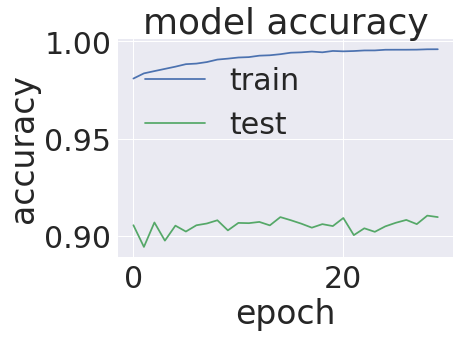

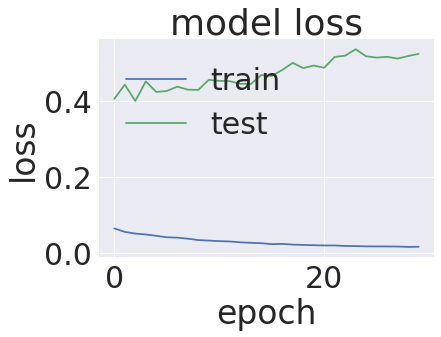

In [75]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing the model


In [76]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_arabic(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


common_american_names = ['zalameh', 'm7mad', 'a5bark', '7elo', 'kefak', 'tamam']
for name in common_american_names:
    print(name, to_arabic(name))

zalameh زلمه
m7mad محمد
a5bark اخبارك
7elo حلو
kefak كيفك
tamam تمام


In [77]:
print(to_arabic('salam'))
print(to_arabic('Peter Parker'))
print(to_arabic('Jonny Snow'))

صلام
بيتاربكر
جننيدو


## Test Data

In [78]:
testing_input = data_input[range_of_val:range_of_val+1000]
testing_output = data_output[range_of_val:range_of_val+1000]
print('testing size', len(testing_input))

testing size 1000


In [79]:
" ".join("asd")

'a s d'

In [80]:
ref = open("ref.txt", "w")
pred = open("pred.txt", "w")

import sys
sum_of_trues=0

i=0
for s,t in zip(testing_input,testing_output):
    sys.stdout.write(str(i)+' ')
    ref.write(" ".join(t)+"\n")
    i+=1
    p = to_arabic(s)
    pred.write(" ".join(p)+"\n")
   # print(s,"=>",to_arabic(s), (to_arabic(s) == t))
    if p == t:
        sum_of_trues+=1
        
print("\nAccuracy=",sum_of_trues/(len(testing_input)))
ref.close()
pred.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [81]:
from bleu import moses_multi_bleu
ref_arr = [i.strip() for i in open("ref.txt").readlines()]
pred_arr = [i.strip() for i in open("pred.txt").readlines()]

moses_multi_bleu(ref_arr, pred_arr)

74.14

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation.

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (model.layers[7]), which is the softmax activation-layer after dot-score. Or we can also simply call model.get_layer('attention') as we previously name the layer as "attention".

In [82]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.input_layer.InputLayer object at 0x7f09f0758b38>	name:input_2
<keras.engine.input_layer.InputLayer object at 0x7f09f0758e48>	name:input_1
<keras.layers.embeddings.Embedding object at 0x7f09efe50cf8>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x7f09efe50780>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x7f09efe55a90>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x7f09efe50748>	name:lstm_1
<keras.layers.merge.Dot object at 0x7f09ec615ef0>	name:dot_1
<keras.layers.core.Activation object at 0x7f09ec615f28>	name:attention
<keras.layers.merge.Dot object at 0x7f09ec615fd0>	name:dot_2
<keras.layers.merge.Concatenate object at 0x7f09ec626c50>	name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x7f09ec62bf28>	name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x7f09ec5d17f0>	name:time_distributed_2


In [83]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 12, 41), (None, 12, 19)]


In [84]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['Osaka'], font_scale=3)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, arabic = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(arabic) , : len(text) ],
        xticklabels=[w for w in text],
        yticklabels=[w for w in arabic])

    ax.invert_yaxis()
    plt.show()

/home/ub05user/virt_env/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

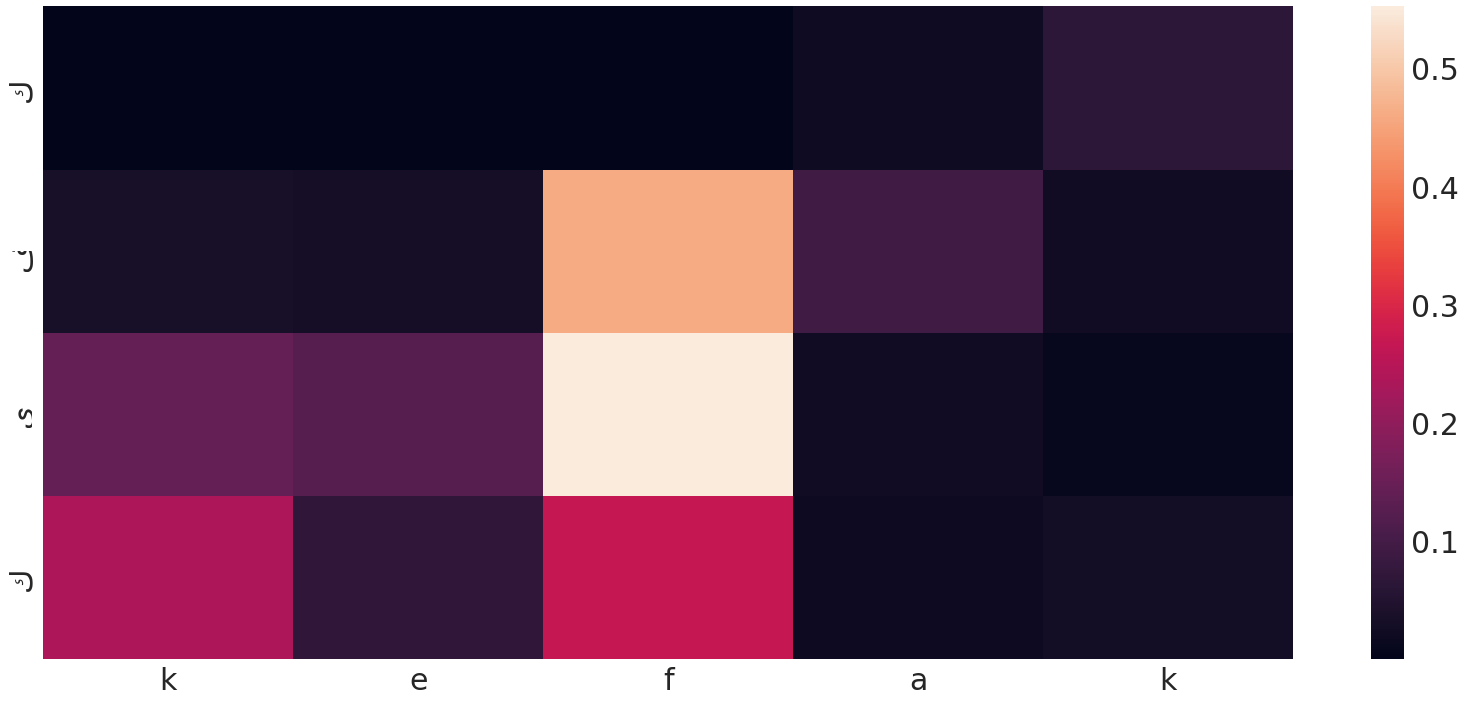

In [85]:
visualize('kefak')
